<a href="https://colab.research.google.com/github/CetinkayaEge/CS210/blob/main/dsa210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import requests

In [63]:
import time

In [90]:
import pandas as pd

I have left the api key because it expires after 24h.

In [30]:
api_key="RGAPI-5ad628dc-79a3-42a7-bad1-19ff793dd9a1"

The api uses puuuid for identifying players in game so we first access it using another call using game name.

In [31]:
puuuid=requests.get("https://europe.api.riotgames.com/riot/account/v1/accounts/by-riot-id/Teyp/TR1"+"?api_key="+apikey)
puuuid=puuuid.json()
puuuid=puuuid["puuid"]

Extracting the match id's.

In [64]:
def get_match_history(puuid, api_key, start, count,queue):
  url = "https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/" + puuid + "/ids?start=" + str(start) + "&count=" + str(count)+ "&queue=" + str(queue)  + "&api_key=" + api_key
  while True:
    response = requests.get(url)
    if(response.status_code==429):
      time.sleep(10)
    else:
      break
  return response.json()

In [65]:
#matchids for ranked solo/duo gametype
matchids=get_match_history(puuuid,api_key,0,100,420)
#matchids for ranked flex gametype
matchids2=get_match_history(puuuid,api_key,0,100,440)

I have put 10 seconds sleep if the request returns 429 which means the request limit has been exceeded because the api has a request limit for every 2 minutes.

In [66]:
def get_match_data(match_id,api_key):
  url="https://europe.api.riotgames.com/lol/match/v5/matches/"+str(match_id)+"?api_key="+str(api_key)
  while True:
    response = requests.get(url)
    if(response.status_code==429):
      time.sleep(10)
    else:
      break
  return response.json()

In [67]:
detailed_match_history1=[]
for match_id in matchids:
  match_data=get_match_data(match_id,api_key)
  detailed_match_history1.append(match_data)

detailed_match_history2=[]
for match_id in matchids2:
  match_data=get_match_data(match_id,api_key)
  detailed_match_history2.append(match_data)


In [140]:
detailed_match_history1[0]

{'metadata': {'dataVersion': '2',
  'matchId': 'TR1_1578770516',
  'participants': ['jgEbXR20PXPIGW5pya93HGFcVXU6vGjjY1tPP9y2upjpyK4IjG7Co-ASMccnNSRlbXUncfsdc0fiMw',
   '8bxOwI8CP0l8TSv7ACeO_XxRjwaOWnZZOL8iZJ0_IQ318ErzD9pf-71Qz953znej1PYKDps14sbtlQ',
   'etXf7XNQuJmepxed400ZNCfxf8GHSa4YoPDA7ptV9_T3eDGlUpBZ2IXRTNPJLdBAnwhTLesIffjGUw',
   'l-n38XHxeYmdbENbrNtZA9xjvVezc3tpnzSv3-gVSm3O_4agjybGHTTxHeTES-BN__rXLXeYtBHnWQ',
   'Uu8C1PUalAtVnJlyL90Az-dA3v8bpYzt9c9TtDevFpR72eVoNCcHCzhLs07qGcueMjOmoMKaAeTEMg',
   'HUB6M31yydZfIYPgrIdtx-jOW4y33JeQAwCd4wmdhNDWC-1O9Gi3_8r35ez9n8aBiNlmUTq7fwHzLQ',
   '0Zqm5LgypTyRCtiOu70hU6nzQLmXVBvuSNGobjJi-7CIxu0Y_rt-raNBdFJOZswvhqkqaeMH-c5cIw',
   'cEJgH4GWoUESU7BXVx7AJ0Sm7c_9K1UU30nwfz9Y_K0oSlEvAzUb-4mT0hrCoHc368SLUXw5Fwg4Nw',
   'HSE8FQaL4QrtJkuzqV7yETgh7uhCZI39WSFAx_oFMlYJb7be6C87HRR1dlDNLGuR-aU56uKMyMfuFw',
   'ynxo6abT78gjs51y_19bE0pwdBQ19943vpEZbwsfr_GXRa-NM8FwRhOw58kMQK-H4jqPOsOrlSHBvQ']},
 'info': {'endOfGameResult': 'GameComplete',
  'gameCreation': 1735

extract the match data for a single player because the request gather data for each player in the game.

---


variables ending with 1 is for solo/duo game type

---


variales ending with 2 is for flex game type

In [141]:
def extract_player_data(detailed_match_history, target_puuid):
  player_data = []
  for match_data in detailed_match_history:
    data=[]
    data.append(match_data['info']['gameDuration'])
    for participant in match_data["info"]["participants"]:
      if participant["puuid"] == target_puuid:
        data.append(participant["kills"])
        data.append(participant["deaths"])
        data.append(participant["assists"])
        data.append(participant["championName"])
        data.append(participant["win"])
        player_data.append(data)
        break
  return player_data

In [142]:
player_data1 = extract_player_data(detailed_match_history1, puuuid)
player_data2 = extract_player_data(detailed_match_history2, puuuid)

transfer the data in to pandas data frame in order to analyze more easily.

In [143]:
columns = ["gameDuration", "kills", "deaths", "assists", "championName", "win"]
df = pd.DataFrame(player_data1, columns=columns)
df2= pd.DataFrame(player_data2, columns=columns)

turn gameduration from seconds to minutes.

In [144]:
df["gameDuration"] = df["gameDuration"] / 60
df2["gameDuration"] = df2["gameDuration"] / 60

add a column called KDA for better representation.Replaces 0's with 1 to prevent division by 0.

In [145]:
df["KDA"] = (df["kills"] + df["assists"]) / df["deaths"].replace(0, 1)
df2["KDA"] = (df2["kills"] + df2["assists"]) / df2["deaths"].replace(0, 1)

In [146]:
print(df.describe())
print(df2.describe())

       gameDuration       kills      deaths     assists         KDA
count    100.000000  100.000000  100.000000  100.000000  100.000000
mean      31.002000    5.020000    6.910000   10.370000    2.901475
std        7.969147    3.829656    3.312343    7.874848    2.932408
min        1.750000    0.000000    0.000000    0.000000    0.000000
25%       27.387500    2.000000    5.000000    4.750000    1.200000
50%       30.766667    4.000000    7.000000    9.000000    1.866071
75%       35.908333    7.000000    9.000000   15.000000    3.562500
max       46.466667   19.000000   19.000000   36.000000   15.000000
       gameDuration       kills      deaths     assists         KDA
count    100.000000  100.000000  100.000000  100.000000  100.000000
mean      29.454167    4.910000    6.550000    7.980000    2.820429
std        7.981797    4.015362    3.441796    5.690644    3.496802
min        2.016667    0.000000    0.000000    0.000000    0.000000
25%       24.595833    2.000000    4.000000    3

In [113]:
print(df["championName"].value_counts())
print(df2["championName"].value_counts())

championName
Chogath        6
Thresh         5
Zac            5
Sejuani        4
Sion           4
Skarner        3
Shen           3
Trundle        3
Ekko           3
Ahri           3
TahmKench      3
Gragas         2
Rammus         2
Jax            2
Yorick         2
Lissandra      2
Lux            2
Milio          2
Urgot          2
Fizz           2
Soraka         2
Nasus          2
Talon          2
JarvanIV       2
Vayne          1
Gwen           1
Ezreal         1
Gnar           1
Quinn          1
Volibear       1
Malphite       1
Pantheon       1
Sivir          1
Fiora          1
DrMundo        1
Renekton       1
Amumu          1
AurelionSol    1
Ornn           1
Braum          1
Twitch         1
Seraphine      1
Morgana        1
Diana          1
Jayce          1
Belveth        1
Briar          1
Elise          1
Vi             1
Karma          1
Lulu           1
Syndra         1
Malzahar       1
Nautilus       1
Jhin           1
Garen          1
Name: count, dtype: int64
championN

In [147]:
win_rate = df["win"].mean()
print("Win Rate:", win_rate)

Win Rate: 0.43


In [148]:
win_rate2 = df2["win"].mean()
print("Win Rate:", win_rate2)

Win Rate: 0.49


using seaborn and matplot to visualise the data

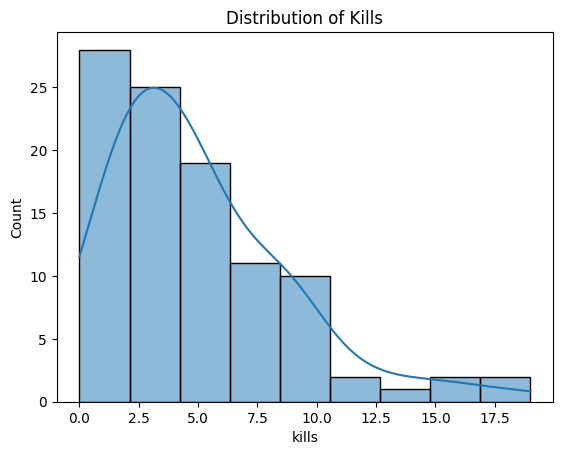

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["kills"], kde=True)
plt.title("Distribution of Kills")
plt.show()

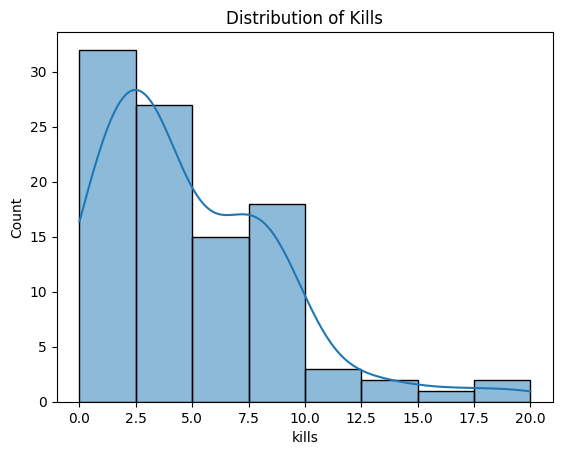

In [150]:
sns.histplot(df2["kills"], kde=True)
plt.title("Distribution of Kills")
plt.show()

champion average win rate

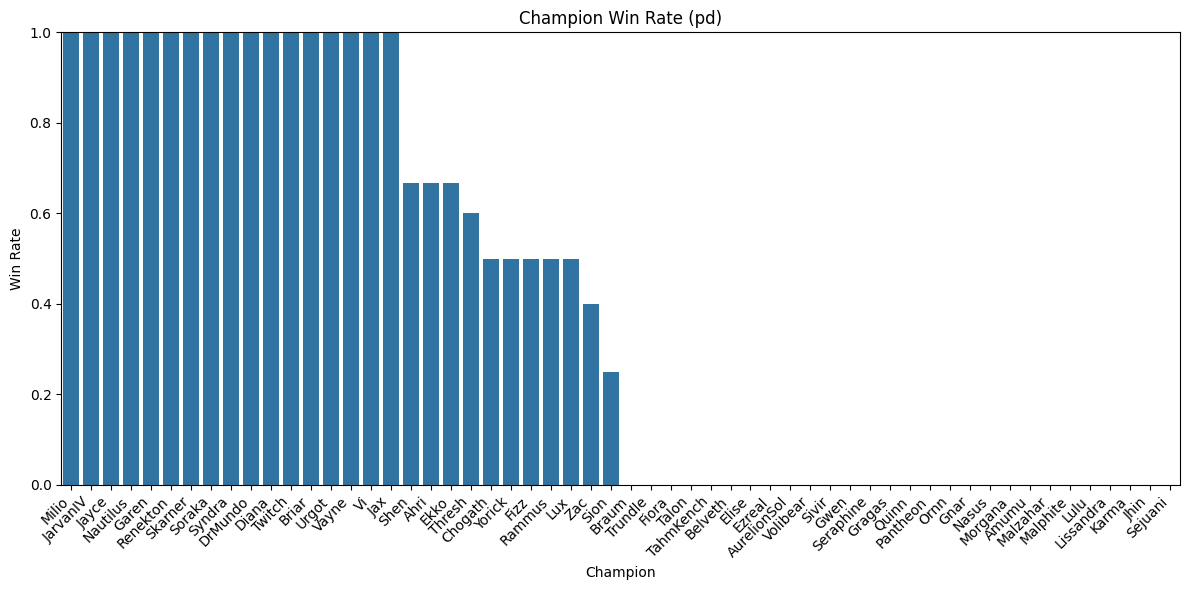

In [151]:
champion_win_rates_pd=df.groupby("championName")["win"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))  # Increase figure size as needed
sns.barplot(x=champion_win_rates_pd.index, y=champion_win_rates_pd.values)
plt.title("Champion Win Rate (pd)")
plt.xlabel("Champion")
plt.ylabel("Win Rate")
# Rotate the x-axis labels so they don't overlap
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # if your win column is in [0,1]
plt.tight_layout()
plt.show()


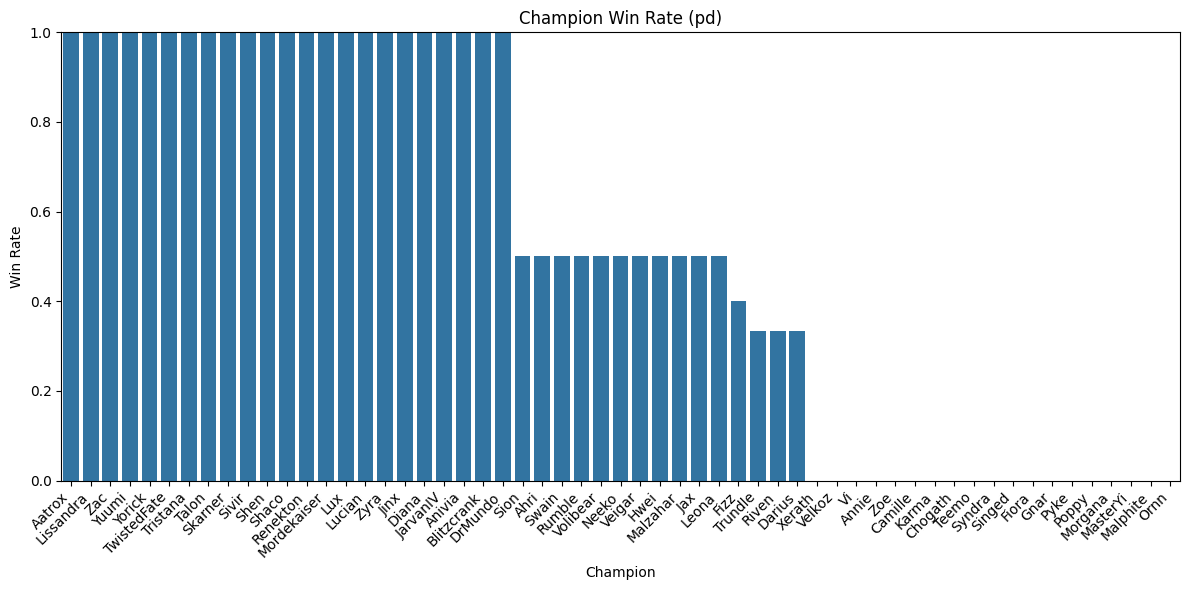

In [152]:
champion_win_rates_pd2=df2.groupby("championName")["win"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))  # Increase figure size as needed
sns.barplot(x=champion_win_rates_pd2.index, y=champion_win_rates_pd2.values)
plt.title("Champion Win Rate (pd)")
plt.xlabel("Champion")
plt.ylabel("Win Rate")
# Rotate the x-axis labels so they don't overlap
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # if your win column is in [0,1]
plt.tight_layout()
plt.show()


game duration and win rate

In [ ]:
bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, float('inf')]
labels = ["0-20","20-25","25-30","30-35","35-40","40-45","45-50","50-55","55-60","60+"]


correlation between variables

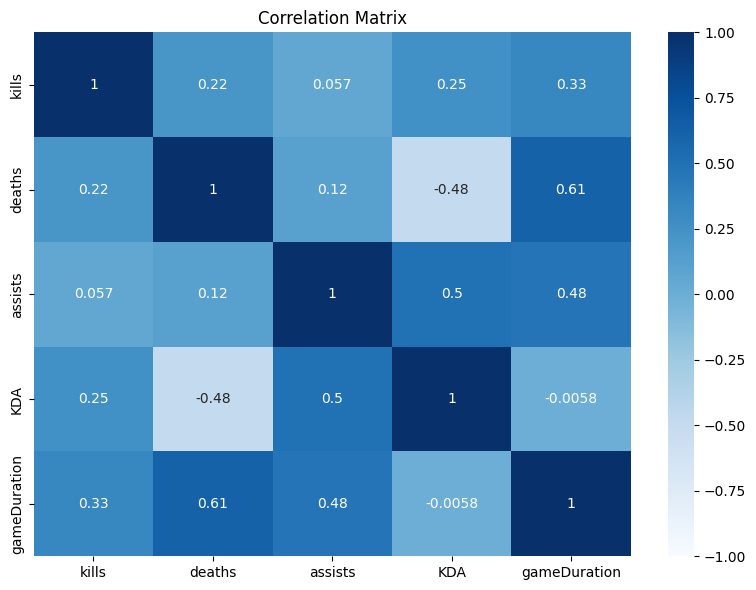

In [154]:
numeric_columns = ["kills", "deaths", "assists", "KDA", "gameDuration"]


corr_matrix1 = df[numeric_columns].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix1, annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

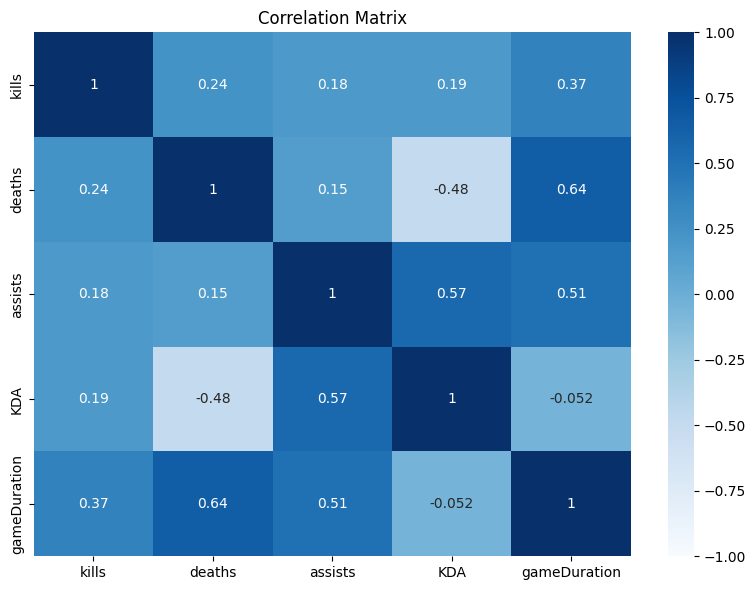

In [156]:
numeric_columns = ["kills", "deaths", "assists", "KDA", "gameDuration"]


corr_matrix2 = df2[numeric_columns].corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix2, annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()